In [1]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-02-03 00:14:08.569247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 00:14:08.646282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 00:14:08.646951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
from tqdm import tqdm
from tensorflow import keras
import random
from scipy import stats
import h5py

In [3]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Activation , Conv2D, MaxPooling2D, AveragePooling2D,Flatten
import numpy as np
import pandas as pd
from keras.losses import SparseCategoricalCrossentropy
import cv2
import os
from os import path
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [4]:
if not path.exists('./models'):
    os.mkdir('./models')
    os.mkdir('./models/labels')
    os.mkdir('./models/weights')

In [5]:
path_1 = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca'
path_2 = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n'
path_3 = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc'


scale_percent = 25
width = int(768 * scale_percent / 100)
height = int(768 * scale_percent / 100)
dsize = (width, height)

image_list_train = np.empty((0,192,192,3), float)
labels_train = []

image_list_test = np.empty((0,192,192,3), float)
labels_test = []

In [6]:
#used instead of the heavy load of images. those files contains the images processed
load_images_flag = True

try:
    image_list_train = np.load('../input/cancer-detection-cnn/train_ds.npy')
    image_list_test = np.load('../input/cancer-detection-cnn/test_ds.npy')
except IOError:
    print("Error: can\'t find file or read data")
    load_images_flag = True
else:
    print ("content has been read successfully")
    load_images_flag = False

labels_train = [0 for i in range(1200)] + [1 for i in range(1200)] + [2 for i in range(1200)]
labels_test = [0 for i in range(300)] + [1 for i in range(300)] + [2 for i in range(300)]

Written content in the file successfully


In [7]:
count = 0

if load_images_flag:
    for img in tqdm(os.listdir(path_1)):
        if count < 1200:
            i = cv2.imread(os.path.join(path_1,img),1)
            i = cv2.resize(i, dsize)
            image_list_train = np.append(image_list_train, np.array([i]), axis=0)
            labels_train.append(0)
        elif count >= 1200 and count < 1500:
            i = cv2.imread(os.path.join(path_1,img),1)
            i = cv2.resize(i, dsize)
            image_list_test = np.append(image_list_test, np.array([i]), axis=0)
            labels_test.append(0)
        elif count >= 1500:
            break
        count += 1

In [8]:
count = 0

if load_images_flag:
    for img in tqdm(os.listdir(path_2)):
        if count < 1200:
            i = cv2.imread(os.path.join(path_2,img),1)
            i = cv2.resize(i, dsize)
            image_list_train = np.append(image_list_train, np.array([i]), axis=0)
            labels_train.append(1)
        elif count >= 1200 and count < 1500:
            i = cv2.imread(os.path.join(path_2,img),1)
            i = cv2.resize(i, dsize)
            image_list_test = np.append(image_list_test, np.array([i]), axis=0)
            labels_test.append(1)
        elif count >= 1500:
            break
        count += 1


In [9]:
count = 0

if load_images_flag:
    for img in tqdm(os.listdir(path_3)):
        if count < 1200:
            i = cv2.imread(os.path.join(path_3,img),1)
            i = cv2.resize(i, dsize)
            image_list_train = np.append(image_list_train, np.array([i]), axis=0)
            labels_train.append(2)
        elif count >= 1200 and count < 1500:
            i = cv2.imread(os.path.join(path_3,img),1)
            i = cv2.resize(i, dsize)
            image_list_test = np.append(image_list_test, np.array([i]), axis=0)
            labels_test.append(2)
        elif count >= 1500:
            break
        count += 1

In [10]:
#scale_percent = 25
#width = int(image_list[0].shape[1] * scale_percent / 100)
#height = int(image_list[0].shape[0] * scale_percent / 100)
#dsize = (width, height)

#for i in range(len(image_list)):
#    image_list[i] = cv2.resize(image_list[i], dsize)

In [11]:
if load_images_flag:
    ind = 0
    while ind < len(image_list_train):
        image_list_train[ind] = stats.zscore(image_list_train[ind])
        ind += 1
    ind = 0
    while ind < len(image_list_test):
        image_list_test[ind] = stats.zscore(image_list_test[ind])
        ind += 1

label
0    1200
1    1200
2    1200
dtype: int64


<AxesSubplot:xlabel='label'>

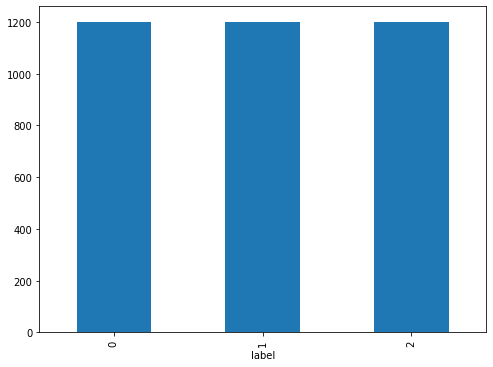

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df = pd.DataFrame(labels_train,columns=['label'],dtype='int')
print(df.groupby('label').size())
df.groupby('label').size().plot.bar(ylim=0)
#plt.show()

In [13]:
n_classes = 3
print("Shape before one-hot encoding: ", np.array(labels_train).shape)
labels_train = np_utils.to_categorical(labels_train, n_classes)
labels_test = np_utils.to_categorical(labels_test, n_classes)
print("Shape after one-hot encoding: ", np.array(labels_train).shape)

Shape before one-hot encoding:  (3600,)
Shape after one-hot encoding:  (3600, 3)


In [14]:
if load_images_flag:
    np.save('./train_ds.npy', image_list_train)
    np.save('./test_ds.npy', image_list_test)

In [15]:
shape = (192,192,3)

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
#model.add(Dense(4096, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))
#opt = keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2022-02-03 00:14:40.214459: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-03 00:14:40.215647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 00:14:40.216469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 00:14:40.217142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [17]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min',restore_best_weights=True)
#mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
mcp_save = ModelCheckpoint(filepath='./models/weights/best_weights.hdf5', monitor='val_accuracy',mode='max',save_best_only=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, mode='min')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 188, 188, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 43, 43, 128)       7

In [19]:
model.fit(image_list_train, labels_train , epochs=50, batch_size=128, validation_data=(image_list_test, labels_test),callbacks=[earlyStopping, mcp_save, reduce_lr_loss], verbose=1)

2022-02-03 00:14:43.011923: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1592524800 exceeds 10% of free system memory.
2022-02-03 00:14:44.704341: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1592524800 exceeds 10% of free system memory.
2022-02-03 00:14:45.900065: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-02-03 00:14:47.473621: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


29/29 [==============================] - 17s 266ms/step - loss: 0.6676 - accuracy: 0.3392 - val_loss: 0.6376 - val_accuracy: 0.3333
Epoch 2/50
29/29 [==============================] - 6s 191ms/step - loss: 0.5592 - accuracy: 0.4414 - val_loss: 0.4202 - val_accuracy: 0.7344
Epoch 3/50
29/29 [==============================] - 5s 189ms/step - loss: 0.3846 - accuracy: 0.7161 - val_loss: 0.3572 - val_accuracy: 0.7167
Epoch 4/50
29/29 [==============================] - 5s 189ms/step - loss: 0.3095 - accuracy: 0.7719 - val_loss: 0.2326 - val_accuracy: 0.8522
Epoch 5/50
29/29 [==============================] - 5s 190ms/step - loss: 0.2341 - accuracy: 0.8508 - val_loss: 0.2391 - val_accuracy: 0.8500
Epoch 6/50
29/29 [==============================] - 6s 191ms/step - loss: 0.1989 - accuracy: 0.8733 - val_loss: 0.1757 - val_accuracy: 0.8911
Epoch 7/50
29/29 [==============================] - 6s 192ms/step - loss: 0.1823 - accuracy: 0.8861 - val_loss: 0.2205 - val_accuracy: 0.8456
Epoch 8/50
29/29

In [20]:
model.load_weights('./models/weights/best_weights.hdf5')

In [21]:
model.save('./models/CNN-cancer-detection.h5')

In [22]:
count = 0

image_list_t = np.empty((0,192,192,3), int)
labels_t = []

for img in os.listdir(path_1):
    if count >= 1550 and count < 1600:
        i = cv2.imread(os.path.join(path_1,img),1)
        i = cv2.resize(i, dsize)
        image_list_t = np.append(image_list_t, np.array([i]), axis=0)
        labels_t.append(0)
    count += 1

count = 0

for img in os.listdir(path_2):
    if count >= 1550 and count < 1600:
        i = cv2.imread(os.path.join(path_2,img),1)
        i = cv2.resize(i, dsize)
        image_list_t = np.append(image_list_t, np.array([i]), axis=0)
        labels_t.append(1)
    count += 1
    

count = 0

for img in os.listdir(path_3):
    if count >= 1550 and count < 1600:
        i = cv2.imread(os.path.join(path_3,img),1)
        i = cv2.resize(i, dsize)
        image_list_t = np.append(image_list_t, np.array([i]), axis=0)
        labels_t.append(2)
    count += 1
    
ind = 0
while ind < 150:
    image_list_t[ind] = stats.zscore(image_list_t[ind])
    ind += 1
    


In [23]:
labels_t = np_utils.to_categorical(labels_t, n_classes)

In [24]:
result= model.predict(image_list_t)

In [25]:
loss, accuracy = model.evaluate(image_list_t,labels_t)
loss, accuracy = model.evaluate(image_list_test, labels_test)

29/29 [==============================] - 0s 15ms/step - loss: 0.0973 - accuracy: 0.9511


In [42]:
labels_test_uncoded = [0 for i in range(50)] + [1 for i in range(50)] + [2 for i in range(50)]

In [47]:
predictions_DL = []
for r in result:
    max_index= np.argmax(r)
    predictions_DL.append(max_index)
    
len(predictions_DL)

150

In [49]:
from sklearn.metrics import confusion_matrix , classification_report

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




Confusion matrix, without normalization
[[45  0  5]
 [ 4 46  0]
 [10  0 40]]
              precision    recall  f1-score   support

         scc       0.76      0.90      0.83        50
           n       1.00      0.92      0.96        50
         aca       0.89      0.80      0.84        50

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.88       150
weighted avg       0.88      0.87      0.88       150



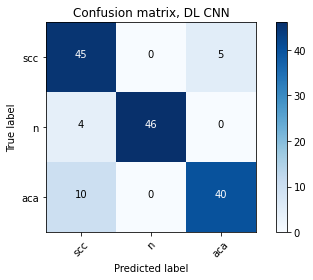

In [61]:
cnf_matrix = confusion_matrix(labels_test_uncoded, predictions_DL)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['scc', 'n', 'aca'],
                      title='Confusion matrix, DL CNN')

print(classification_report(labels_test_uncoded, predictions_DL, target_names=['scc', 'n', 'aca']))

# Transfer Learning : Feature Extraction

In [27]:
l_model = keras.models.load_model('../input/cancer-detection-cnn/models/CNN-cancer-detection-96.h5')

In [31]:
print("Feature extraction from the model...")
feature_extractor = Model(
   inputs=l_model.inputs,
   outputs=l_model.layers[-3].output)

features = feature_extractor.predict(image_list_train)
f_t = feature_extractor.predict(image_list_t)
print("Done !")

labels_train_s = [0 for i in range(1200)] + [1 for i in range(1200)] + [2 for i in range(1200)]
labels_test_s = [0 for i in range(50)] + [1 for i in range(50)] + [2 for i in range(50)]

Feature extraction from the model...


2022-02-03 00:22:19.505883: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1592524800 exceeds 10% of free system memory.


Done !


In [32]:
from sklearn import svm
clf = svm.SVC()
clf.fit(features, labels_train_s)

SVC()

In [33]:
clf.score(f_t,labels_test_s)

0.9133333333333333

In [58]:
predictions_SVM = []
for f in f_t:
    max_index= clf.predict([f])
    predictions_SVM.append(max_index)
    
len(predictions_SVM)

150

Confusion matrix, without normalization
[[48  0  2]
 [ 1 49  0]
 [10  0 40]]
              precision    recall  f1-score   support

         scc       0.81      0.96      0.88        50
           n       1.00      0.98      0.99        50
         aca       0.95      0.80      0.87        50

    accuracy                           0.91       150
   macro avg       0.92      0.91      0.91       150
weighted avg       0.92      0.91      0.91       150



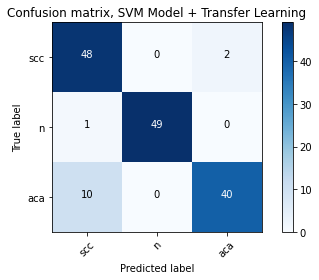

In [60]:
cnf_matrix = confusion_matrix(labels_test_uncoded, predictions_SVM)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['scc', 'n', 'aca'],
                      title='Confusion matrix, SVM Model + Transfer Learning')

print(classification_report(labels_test_uncoded, predictions_SVM, target_names=['scc', 'n', 'aca']))